#Cross-pol investigations

In [2]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')


freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [7]:
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]


def get_slice_xy(xes,yes,val,ax='x'):
    tol = 2
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col

def get_slice(X,Y,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            tol = abs(Y[0,1] - Y[0,0])/1.5
            sliceIndex = np.where((Y[0,:] < (val + tol)) & (Y[0,:] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v': #keeping the x value constant and changing the y value 
            tol = abs(X[1,0] - X[0,0])/1.5
            sliceIndex = np.where((X[:,0] < (val+tol)) & (X[:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]


def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    return stat

In [4]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

find = 900

cmm = cm.magma
fsz=16

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY618_Corrected_amplitudes.pkl' 'FLY619_Corrected_amplitudes.pkl'
 'FLY620_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625

In [5]:
## Look at amplitudes from flight 618, 619 620, 623, 625:

pflights = ['618','619','623','625']
normarr = np.zeros([1024,16,len(pflights)])

for i, fly in enumerate(pflights):
    if fly == '618':
        normarr[:,i] = 1.0
    elif fly == '620':
        normarr[:,i] = 1.0
    elif fly in Npolflights[1::]:
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        Gamp = np.swapaxes(fits['G_popt'][:,:,0],0,1)
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,i] = Gamp*amps[0,:,:]
    elif fly in Epolflights[1::]:
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        Gamp = np.swapaxes(fits['G_popt'][:,:,0],0,1)
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,i] = Gamp*amps[0,:,:]
    

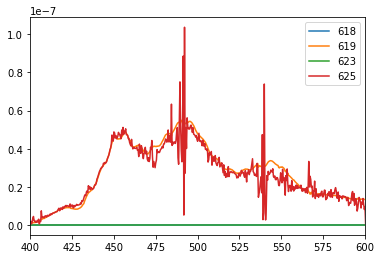

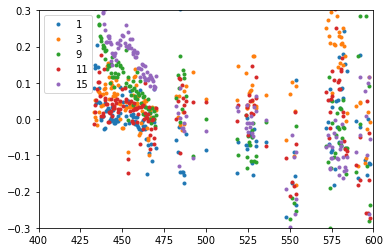

1 -0.01496464196153641
3 0.06248269084461298
9 0.038880492206877594
11 0.012771245588682697
15 0.07656633273399906


In [5]:
for i, fly in enumerate(pflights):
    plt.plot(freqs,normarr[:,1,i],label=fly)
plt.xlim(400,600)
plt.legend()
plt.show()

for p in N_pols:
    plt.plot(freqs[good_freqs],
             2*(normarr[good_freqs,p,3]-normarr[good_freqs,p,1])/(normarr[good_freqs,p,3]+normarr[good_freqs,p,1]),
             label=str(p),marker='.',linestyle='None')
plt.xlim(400,600)
plt.ylim(-0.3,0.3)
plt.legend()
plt.show()

for p in N_pols:
    tt = np.mean(2*(normarr[good_freqs,p,3]-normarr[good_freqs,p,1])/(normarr[good_freqs,p,3]+normarr[good_freqs,p,1]),axis=0)
    print(p, tt)

In [12]:
## repeat the below, in polar coordinates
## comes down to:
# cross pol for E-pols = gain_620*signal_618/signal_620
# cross pol for N-pols = signal_620/signal_618

# since I didn't get relative gains between pols per flight
# I can't apply relative gains, best I can do is try to estimate
# how bad it is not to include it


beam618=bp.Beammap(flightmasterpath='/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml',\
                 concatlist=pcklarr[[4]],gfitlist=gfitarr[[4]],normalization='none',operation='coadd',\
                 coordsys='polar',d0args=[0,360*(np.pi/180.0),6*(np.pi/180.0)],d1args=[0,25*(np.pi/180.0),0.5*(np.pi/180.0)],\
                 #Fargs=[0,1024,1],f_index=900)\
                 Fargs=[900,901,1],f_index=900,vplot=False)



start of concat loop is: 2023-11-28 16:48:45.542619
end of concat loop is: 2023-11-28 16:48:50.063596          


In [18]:
beam618=bp.Beammap(flightmasterpath='/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml',\
                 concatlist=pcklarr[[4]],gfitlist=gfitarr[[4]],normalization='none',operation='coadd',\
                 coordsys='cartesian',d0args=[-80,80,2.5],d1args=[-80,80,2.5],\
                 #Fargs=[0,1024,1],f_index=900)\
                 Fargs=[900,901,1],f_index=900,vplot=False)

start of concat loop is: 2023-11-28 16:52:36.428745
end of concat loop is: 2023-11-28 16:52:39.472851          


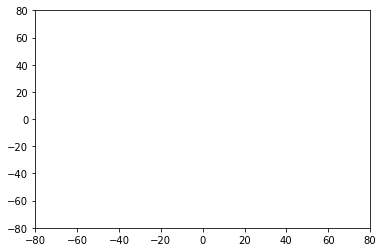

In [20]:
plt.pcolormesh(beam618.d0_edges_grid[:,:,chind],beam618.d1_edges_grid[:,:,chind],
                beam618.V_LC_operation[:,:,0,chind])

<ipython-input-7-4bfd999fa2a0>:13: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0, i].pcolormesh(beam618.d0_edges_grid[:,:,chind],beam618.d1_edges_grid[:,:,chind],
<ipython-input-7-4bfd999fa2a0>:23: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axs[1, i].pcolormesh(beam618.d0_edges_grid[:,:,chind],beam618.d1_edges_grid[:,:,chind],


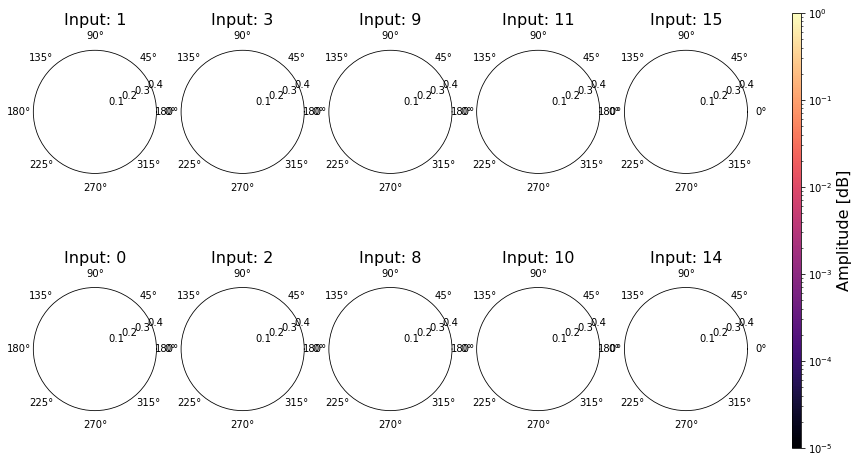

In [7]:
ccm = cm.magma
fsz = 16

fig, axs = plt.subplots(2, 5, subplot_kw=dict(projection="polar"),figsize=(16,8))


for i,chind in enumerate(N_pols):
    axs[0, i].pcolormesh(beam618.d0_edges_grid[:,:,chind],beam618.d1_edges_grid[:,:,chind],
                beam618.V_LC_operation[:,:,0,chind],cmap=ccm,vmin=1E-5,vmax=1,norm=LogNorm())
    axs[0, i].set_title('Input: '+str(chind),fontsize=fsz)




for i,chind in enumerate(E_pols):
    im = axs[1, i].pcolormesh(beam618.d0_edges_grid[:,:,chind],beam618.d1_edges_grid[:,:,chind],
                beam618.V_LC_operation[:,:,0,chind],cmap=ccm,vmin=1E-5,vmax=1,norm=LogNorm())
    axs[1, i].set_title('Input: '+str(chind),fontsize=fsz)
    #axs[1, i].colorbar()


cbar=fig.colorbar(im,ax=axs,aspect=50)
cbar.set_label('Amplitude [dB]',fontsize=fsz)

In [ ]:
## Plan: ##
# 1. Read in flight 618 (N pol flight)
# 2. divide N pols by corresponding Gaussian fits
# 3. read in Gauss fits for flight 620 (Epol flight)
# 4. divide E pols by flight 620 Gauss fits
# 5. Read in 620 flight
# 6. divide E pols by 620 fits
# 7. overplot E-pol copol (flight 620) and Epol cross pol (flight 618)
# 8. divide N pols in 620 with Gaussian fits for 618
# 9. overplot N pol copol (flight 618) and Npol cross pol (flight 620)

In [21]:
##############################################
##### This is with raw data and concats ######
##############################################

# Read in Flight 618
fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest)

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest618=pickle.load(pfile)
t_cut_618=concattest618.inds_on    

fly = '620'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest)

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest620=pickle.load(pfile)
t_cut_620=concattest620.inds_on    

618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/F

In [22]:
## Read in Gaussian fit params:

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits618 = np.load(ffile)
gp_618 = fits618['G_popt'][:,:,0] # amplitude

print(gp_618)

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits620 = np.load(ffile)
gp_620 = fits620['G_popt'][:,:,0] # amplitude

print(gp_620)

[[           nan 1.12507297e-11 1.03401364e-11 ... 2.21110678e-10
  1.73971254e-10 1.33771029e-10]
 [8.28151530e-09 2.88838860e-10 5.79262356e-10 ... 1.27754305e-09
  1.22742222e-09 1.15288538e-09]
 [2.28087767e-09 1.13378084e-10 1.15745340e-10 ... 1.43966192e-10
  1.45536032e-10 1.37248491e-10]
 ...
 [           nan            nan            nan ...            nan
             nan            nan]
 [1.71361994e-10 1.47711512e-11 1.56880649e-11 ... 5.77082524e-11
  3.79459388e-11 5.08132761e-11]
 [7.45100472e-09 1.07213692e-08 1.07832867e-08 ... 3.15769594e-09
  3.14032216e-09 3.11583239e-09]]
[[ 0.00000000e+00  1.74487994e-09  1.74311253e-09 ...  9.55955692e-10
   9.12808615e-10  8.67029837e-10]
 [ 3.63651681e-09 -2.01270590e-11  7.35797924e-09 ...  1.65152129e-10
   1.13489178e-10  2.37949020e-10]
 [ 7.87048609e-09  5.11090450e-09  5.17700944e-09 ...  2.36430851e-09
   2.34750625e-09  2.30763595e-09]
 ...
 [ 0.00000000e+00             nan             nan ...             nan
          

[ 4.28831085e-08 -2.85748077e+00  9.75495920e+00  1.34109007e+00
  9.17015906e+00  4.52712120e-10  0.00000000e+00]


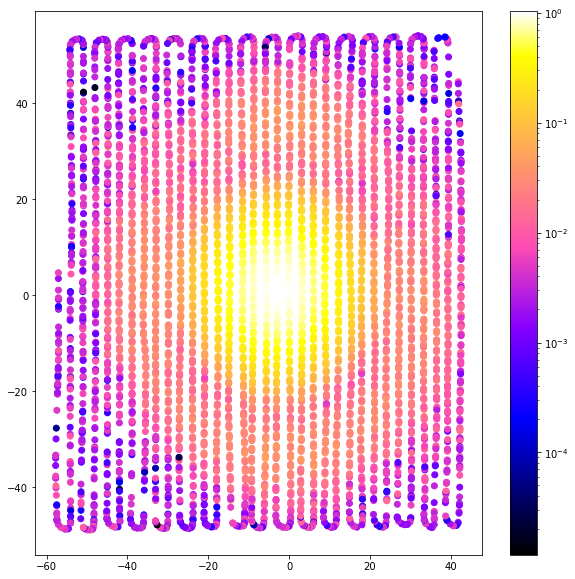

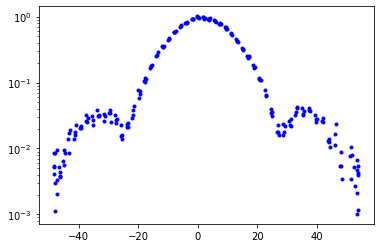

In [23]:
## Let's start by checking regular co-pol normalization - N pol: 

chind=1
print(concattest618.G_popt[chind,find,:])

x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]


# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'b.',label='copol')
plt.show()


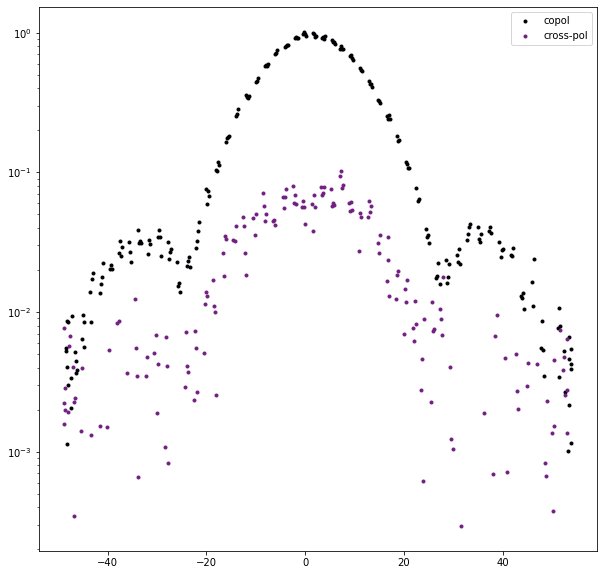

In [28]:
## Now let's plot slices together - N pol
colors=pu.cm_to_discrete(cmm, 3)

# Flight 618, N pol (1 is a good input)
chind=1

x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice

plt.figure(1,figsize=(10,10))
plt.semilogy(y[ixd],z[ixd],color=colors[0],marker='.',linestyle='None',label='copol')

## Let's look at that same channel, in cross-pol flight, divide by same value:

x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]


# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],color=colors[1],marker='.',linestyle='None',label='cross-pol')
plt.legend()
plt.show()

3.5223832952415695e-08


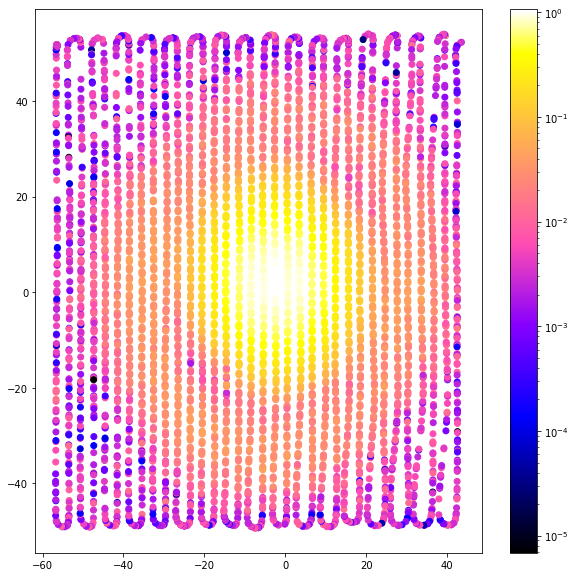

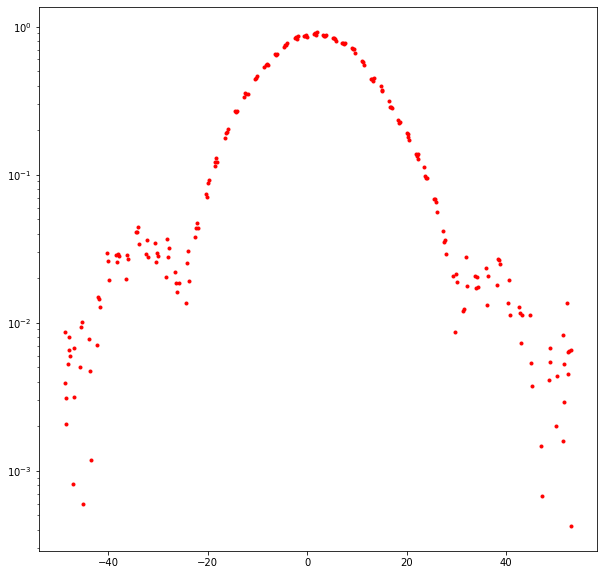

In [29]:
# Repeat for E pol

chind=0
x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / np.abs(gp_620[chind,find])
print(gp_620[chind,find])

# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()

# grab a slice and plot it
plt.figure(1,figsize=(10,10))
ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')



3.5223832952415695e-08


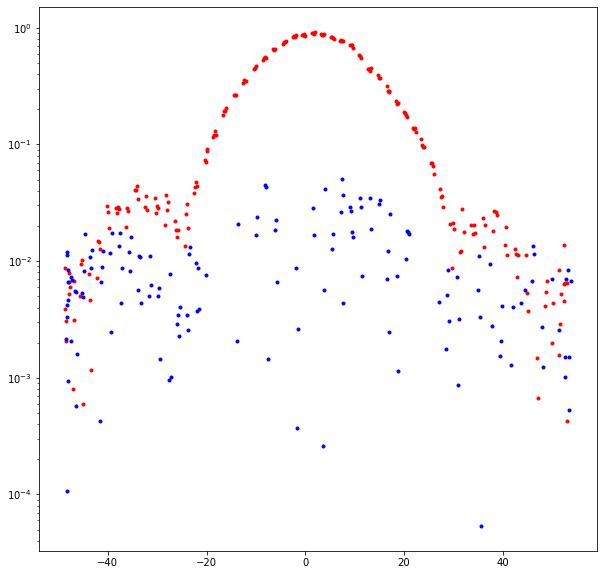

In [30]:
# Now reverse - plot slices together, E pol

# Flight 620, E pol (0 is a good input)
chind=0
x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / np.abs(gp_620[chind,find])
print(gp_620[chind,find])


# grab a slice and plot it
plt.figure(1,figsize=(10,10))
ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')

# Flight 618, N pol (1 is a good input)
x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_620[chind,find]

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'b.',label='copol')
plt.show()



In [32]:
len(N_pols)

5

[ 4.28831085e-08 -2.85748077e+00  9.75495920e+00  1.34109007e+00
  9.17015906e+00  4.52712120e-10  0.00000000e+00]


<ipython-input-33-33e8ac0b848d>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,5,i+1)
<ipython-input-33-33e8ac0b848d>:24: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
<ipython-input-33-33e8ac0b848d>:34: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.scatter(xcrs,ycrs,c=

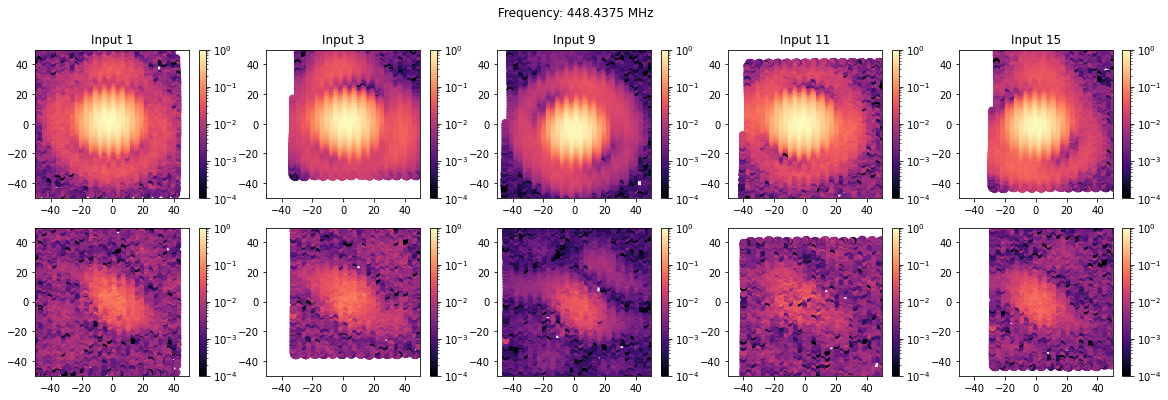

In [33]:
## Now let's plot slices together - N pol
colors=pu.cm_to_discrete(cmm, 3)
find = 900

chind=1
print(concattest618.G_popt[chind,find,:])

fig = plt.figure(figsize=(20,6))
plt.subplot(2,5,1)

for i,chind in enumerate(N_pols):
    # Flight 618, N pol (1 is a good input)
    xco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    yco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zco = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    ycrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zcrs = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]

    # plot scatter plot and beam map
    plt.subplot(2,5,i+1)
    plt.scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
    plt.title('Input '+str(chind))
    plt.ylim(-50,50)
    plt.xlim(-50,50)
    plt.colorbar()
    #plt.show()
    
    # plot scatter plot and beam map
    
    plt.subplot(2,5,6+i)
    plt.scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
    plt.colorbar()
    plt.ylim(-50,50)
    plt.xlim(-50,50)
plt.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()






<ipython-input-34-8f0b682fe78b>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,5,i+1)


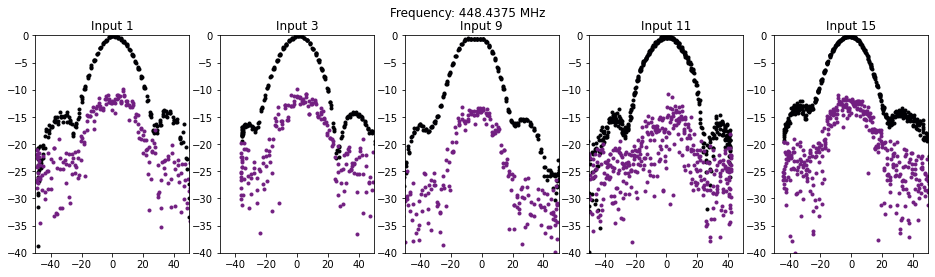

In [34]:
fig = plt.figure(figsize=(16,4))
plt.subplot(1,5,1)

for i,chind in enumerate(N_pols):
    # Flight 618, N pol (1 is a good input)
    xco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    yco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zco = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    ycrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zcrs = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]
    
    ixd = get_slice_xy(xco,yco,0.0,ax='x') # grabbed x slice
    plt.subplot(1,5,i+1)
    plt.title('Input '+str(chind))
    plt.plot(yco[ixd],10*np.log10(abs(zco[ixd])),color=colors[0],marker='.',linestyle='None',label='copol')
    plt.ylim(-40,0)
    plt.xlim(-50,50)
    
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x') # grabbed x slice
    plt.plot(ycrs[ixd],10*np.log10(abs(zcrs[ixd])),color=colors[1],marker='.',linestyle='None',label='cross-pol')
    plt.ylim(-40,0)
    plt.xlim(-50,50)

plt.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()


[ 4.28831085e-08 -2.85748077e+00  9.75495920e+00  1.34109007e+00
  9.17015906e+00  4.52712120e-10  0.00000000e+00]


<ipython-input-36-46ee44415fe3>:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
<ipython-input-36-46ee44415fe3>:33: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axs[1,i].scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
<ipython-input-36-46ee44415fe3>:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0

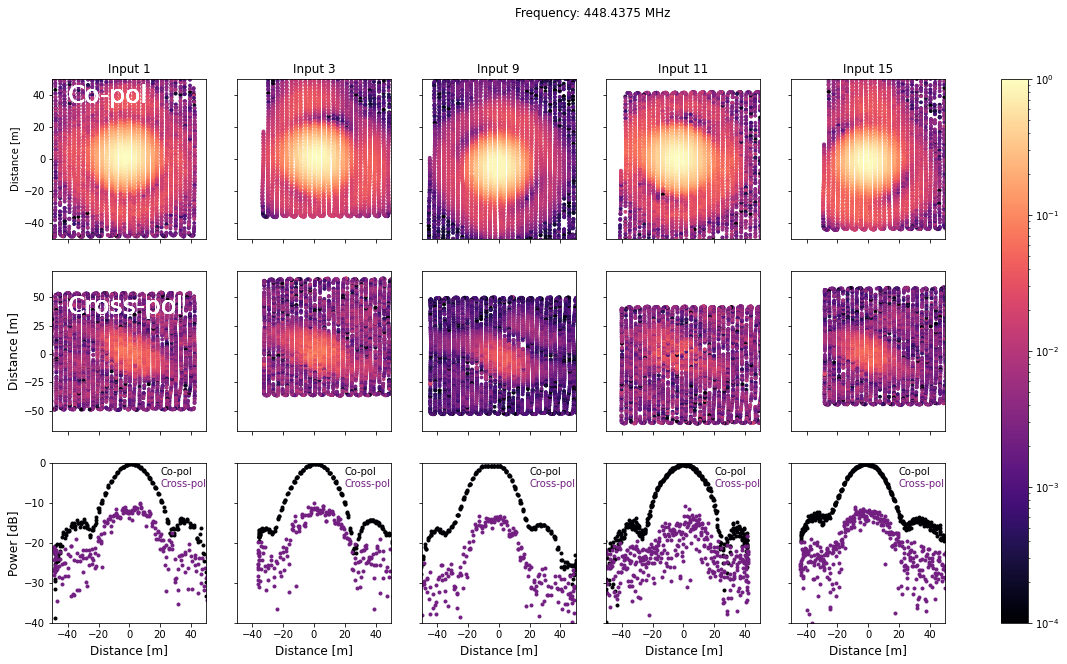

In [36]:
## Now let's plot slices together - N pol
colors=pu.cm_to_discrete(cmm, 3)
find = 900

chind=1
print(concattest618.G_popt[chind,find,:])

fig, axs = plt.subplots(3,5, sharex=True,sharey='row',figsize=(20,10))

for i,chind in enumerate(N_pols):
    # Flight 618, N pol (1 is a good input)
    xco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    yco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zco = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    ycrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zcrs = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]

    # plot scatter plot and beam map
    axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
    axs[0,0].text(-40,35,'Co-pol',color='white',fontsize=25)
    axs[0,0].set_ylabel('Distance [m]',fontsize=10)
    axs[0,i].set_title('Input '+str(chind))
    
    axs[0,i].set_ylim(-50,50)
    axs[0,i].set_xlim(-50,50)
    #axs[0,i].colorbar()
    
    # plot scatter plot and beam map
    
    im = axs[1,i].scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
    axs[1,0].text(-40,35,'Cross-pol',color='white',fontsize=25)
    axs[1,0].set_ylabel('Distance [m]',fontsize=12)
    #axs[1,i].colorbar()
    #axs[1,i].ylim(-50,50)
    #axs[1,i].xlim(-50,50)
    
    
    # plot a cross-section
    ixd = get_slice_xy(xco,yco,0.0,ax='x') # grabbed x slice
    axs[2,i].plot(yco[ixd],10*np.log10(abs(zco[ixd])),color=colors[0],marker='.',linestyle='None',label='copol')
    
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x') # grabbed x slice
    axs[2,i].plot(ycrs[ixd],10*np.log10(abs(zcrs[ixd])),color=colors[1],marker='.',linestyle='None',label='cross-pol')
    axs[2,i].text(20,-3,'Co-pol',color=colors[0])
    axs[2,i].text(20,-6,'Cross-pol',color=colors[1])
    axs[2,0].set_ylabel('Power [dB]',fontsize=12)
    axs[2,i].set_ylim(-40,0.1)
    axs[2,i].set_xlim(-50,50)
    axs[2,i].set_xlabel('Distance [m]',fontsize=12)
fig.colorbar(im, ax=axs.ravel().tolist())   
fig.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()

[ 4.28831085e-08 -2.85748077e+00  9.75495920e+00  1.34109007e+00
  9.17015906e+00  4.52712120e-10  0.00000000e+00]


<ipython-input-41-779bb0744478>:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
<ipython-input-41-779bb0744478>:33: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axs[1,i].scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
<ipython-input-41-779bb0744478>:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0

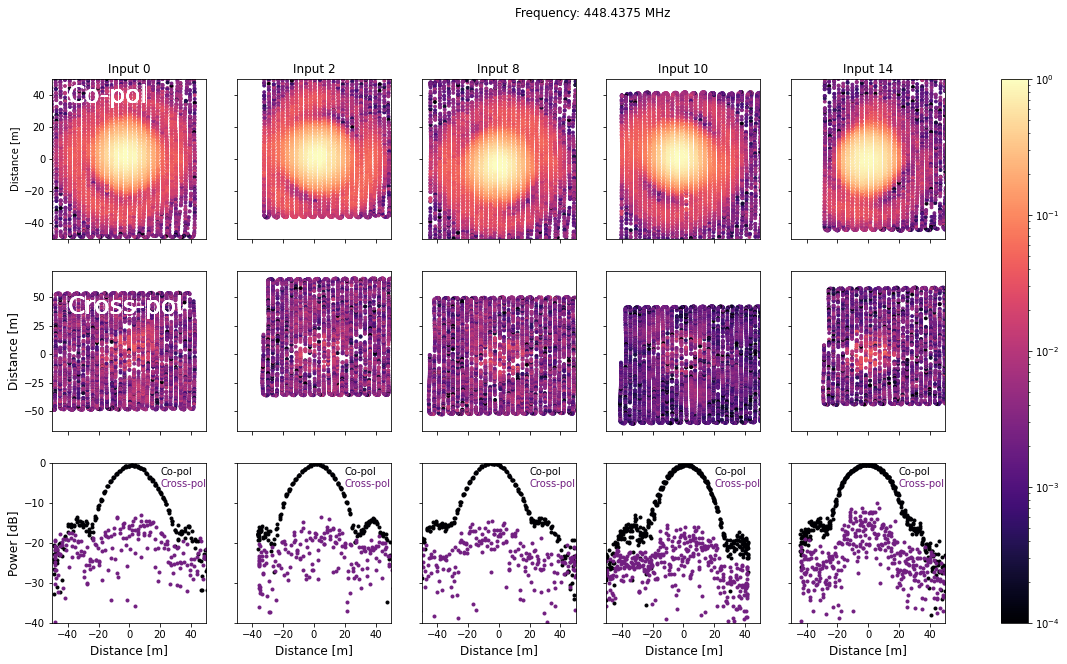

In [41]:
## Now let's plot slices together - E pol
colors=pu.cm_to_discrete(cmm, 3)
find = 900

chind=1
print(concattest618.G_popt[chind,find,:])

fig, axs = plt.subplots(3,5, sharex=True,sharey='row',figsize=(20,10))

for i,chind in enumerate(E_pols):
    # Flight 620, E pol (0 is a good input)
    xco = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    yco = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zco = concattest620.V_bgsub[t_cut_620,find,chind] / gp_620[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    ycrs = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zcrs = concattest618.V_bgsub[t_cut_618,find,chind] / gp_620[chind,find]

    # plot scatter plot and beam map
    axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
    axs[0,0].text(-40,35,'Co-pol',color='white',fontsize=25)
    axs[0,0].set_ylabel('Distance [m]',fontsize=10)
    axs[0,i].set_title('Input '+str(chind))
    
    axs[0,i].set_ylim(-50,50)
    axs[0,i].set_xlim(-50,50)
    #axs[0,i].colorbar()
    
    # plot scatter plot and beam map
    
    im = axs[1,i].scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
    axs[1,0].text(-40,35,'Cross-pol',color='white',fontsize=25)
    axs[1,0].set_ylabel('Distance [m]',fontsize=12)
    #axs[1,i].colorbar()
    #axs[1,i].ylim(-50,50)
    #axs[1,i].xlim(-50,50)
    
    
    # plot a cross-section
    ixd = get_slice_xy(xco,yco,0.0,ax='x') # grabbed x slice
    axs[2,i].plot(yco[ixd],10*np.log10(abs(zco[ixd])),color=colors[0],marker='.',linestyle='None',label='copol')
    
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x') # grabbed x slice
    axs[2,i].plot(ycrs[ixd],10*np.log10(abs(zcrs[ixd])),color=colors[1],marker='.',linestyle='None',label='cross-pol')
    axs[2,i].text(20,-3,'Co-pol',color=colors[0])
    axs[2,i].text(20,-6,'Cross-pol',color=colors[1])
    axs[2,0].set_ylabel('Power [dB]',fontsize=12)
    axs[2,i].set_ylim(-40,0.1)
    axs[2,i].set_xlim(-50,50)
    axs[2,i].set_xlabel('Distance [m]',fontsize=12)
fig.colorbar(im, ax=axs.ravel().tolist())   
fig.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()

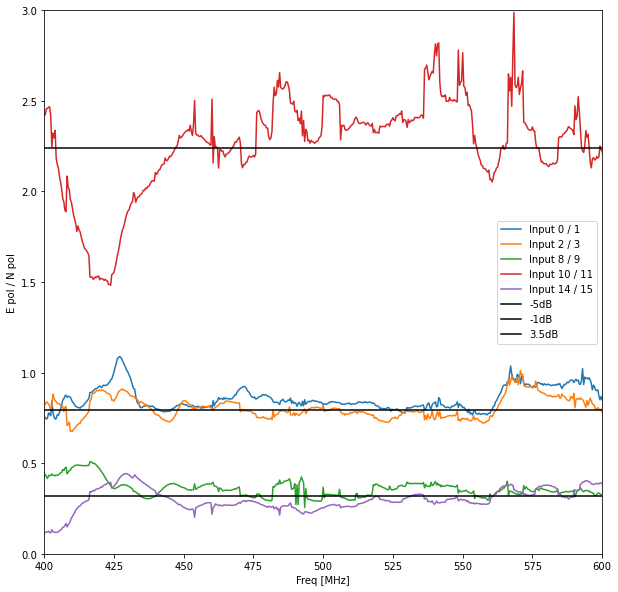

In [37]:
# check the ratio of gains between X and Y pols, to compare to 360 rotations
plt.figure(1,figsize=(10,10))
for chind in pols:
    plt.plot(freqs,gp_620[chind,:]/gp_618[chind+1,:],label='Input '+str(chind)+' / '+str(chind+1))
plt.xlim(400,600)
plt.ylim(0,3)
plt.axhline(10**(-5.0/10.),label='-5dB',color='black')
plt.axhline(10**(-1/10.),label='-1dB',color='black')
plt.axhline(10**(3.5/10.),label='3.5dB',color='black')
plt.ylabel('E pol / N pol')
plt.xlabel('Freq [MHz]')
plt.legend()
plt.show()

In [15]:
# That's all great, let's actually make a beam and stuff though for the slicing

# This doesn't work, it seems like the code is actually using the gaussian fits for the cross pol and applyng
# them, not worth futzing with right now

pflights = ['618','620']

find=900

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.ones([64,64,16,len(pflights)])

fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest[fi])

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest1=pickle.load(pfile)
t_cut=concattest1.inds_on

beam618=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='none',operation='coadd',d0args=[-1*sz,sz,2.5],
                 d1args=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)


fly = '620'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest[fi])

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest1=pickle.load(pfile)
t_cut=concattest1.inds_on

beam620=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='none',operation='coadd',d0args=[-1*sz,sz,2.5],
                 d1args=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)

618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'>
start of concat loop is: 2023-12-01 21:35:05.793094
end of concat loop is: 2023-12-01 21:35:09.543683          


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:366: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


620 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl'>
start of concat loop is: 2023-12-01 21:35:15.321899
end of concat loop is: 2023-12-01 21:35:19.213679          


(64, 64, 1, 16, 1)

<ipython-input-19-738379463ebd>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xco,yco,zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
<ipython-input-19-738379463ebd>:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.pcolormesh(xco,yco,zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())


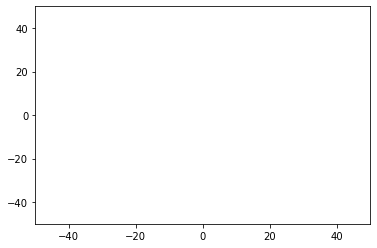

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


In [19]:
# Flight 618, N pol (1 is a good input)
xco = beam618.d0_centers_grid[:,:,0]
yco = beam618.d1_centers_grid[:,:,0]
zco = beam618.V_LC_operation[:,:,0,chind] 

## Let's look at that same channel, in cross-pol flight, divide by same value:
xcrs = beam620.d0_centers_grid[:,:,0]
ycrs = beam620.d1_centers_grid[:,:,0]
zcrs = beam620.V_LC_mean[:,:,0,chind,0] / gp_618[chind,find]

plt.pcolormesh(xco,yco,zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
plt.ylim(-50,50)
plt.xlim(-50,50)
plt.show()

print(zco[:,30])

<ipython-input-11-3ae8c99a5f24>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0,i].pcolormesh(xco,yco,zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
<ipython-input-11-3ae8c99a5f24>:32: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0,i].pcolormesh(xco,yco,zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())


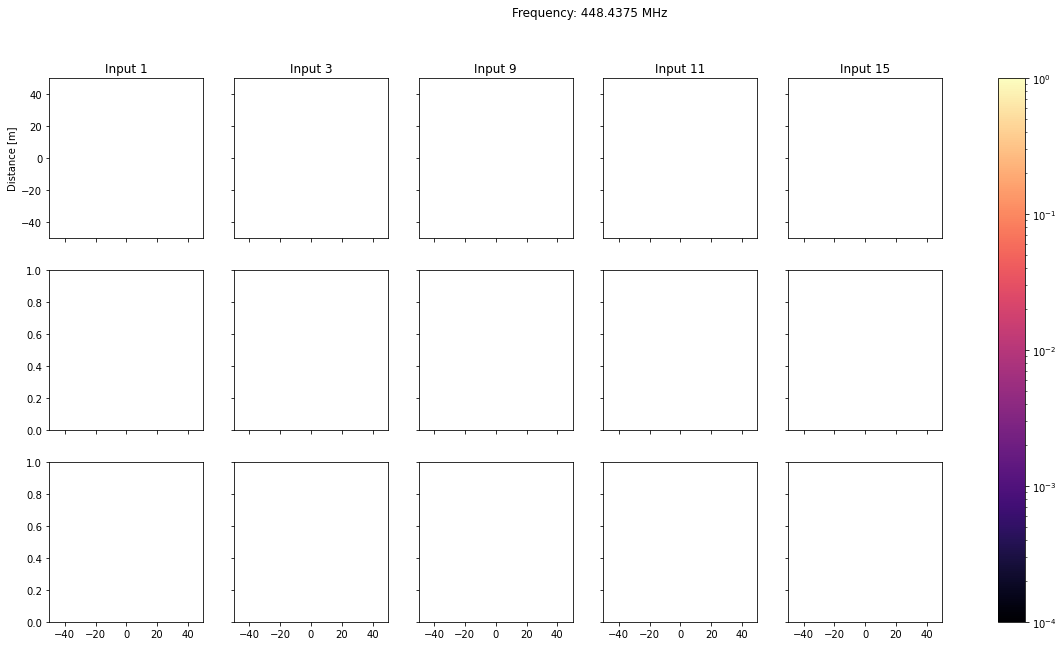

In [11]:
## Read in Gaussian fit params:

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits618 = np.load(ffile)
gp_618 = fits618['G_popt'][:,:,0] # amplitude

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits620 = np.load(ffile)
gp_620 = fits620['G_popt'][:,:,0] # amplitude


## Now let's plot slices together - N pol
colorz=pu.cm_to_discrete(cmm, 3)
find = 900

fig, axs = plt.subplots(3,5, sharex=True,sharey='row',figsize=(20,10))

for i,chind in enumerate(N_pols):
    # Flight 618, N pol (1 is a good input)
    xco = beam618.d0_centers_grid[:,:,0]
    yco = beam618.d1_centers_grid[:,:,0]
    zco = beam618.V_LC_mean[:,:,0,chind,0] / gp_618[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = beam620.d0_centers_grid[:,:,0]
    ycrs = beam620.d1_centers_grid[:,:,0]
    zcrs = beam620.V_LC_mean[:,:,0,chind,0] / gp_618[chind,find]

    # plot scatter plot and beam map
    axs[0,i].pcolormesh(xco,yco,zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
    axs[0,0].text(-40,35,'Co-pol',color='white',fontsize=25)
    axs[0,0].set_ylabel('Distance [m]',fontsize=10)
    axs[0,i].set_title('Input '+str(chind))
    
    axs[0,i].set_ylim(-50,50)
    axs[0,i].set_xlim(-50,50)
    #axs[0,i].colorbar()
    
    # plot scatter plot and beam map
    
#    im = axs[1,i].pcolormesh(xcrs,ycrs,zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
#    axs[1,0].text(-40,35,'Cross-pol',color='white',fontsize=25)
#    axs[1,0].set_ylabel('Distance [m]',fontsize=12)
#    #axs[1,i].colorbar()
#    #axs[1,i].ylim(-50,50)
#    #axs[1,i].xlim(-50,50)
#    
#    
#    # plot a cross-section
#    xx = 0
#    chind = pols[0]
#    colx = get_slice(beam618.d0_centers_grid[:,:,chind],beam618.d1_centers_grid[:,:,chind],
#                 beam618.V_LC_operation[:,:,0,chind],xx,'v')
#
#    axs[2,i].semilogy(beam.d1_centers_grid[colx,:,0],10*np.log10(zco[colx,:]),'o',
#             color=colorz[i],label='copol')
#    axs[2,i].semilogy(beam.d1_centers_grid[colx,:,0],10*np.log10(zcrs[colx,:]),'o',
#             color=colorz[i],label='crosspol')
#    axs[2,i].text(20,-3,'Co-pol',color=colors[0])
#    axs[2,i].text(20,-6,'Cross-pol',color=colors[1])
#    axs[2,0].set_ylabel('Power [dB]',fontsize=12)
#    axs[2,i].set_ylim(-40,0.1)
#    axs[2,i].set_xlim(-50,50)
#    axs[2,i].set_xlabel('Distance [m]',fontsize=12)
fig.colorbar(im, ax=axs.ravel().tolist())   
fig.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()